In [3]:
# %pip install simple-icd-10

In [4]:
# %pip install seaborn

In [5]:
import os
import pandas as pd
import json
import re
import simple_icd_10 as icd
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 1000)

In [45]:
MODEL = "qwen3-235b-a22b_0"
RESPONSES_PATH = f"responses/responses_{MODEL}.tsv"

In [46]:
responses = pd.read_csv(RESPONSES_PATH, sep="\t")

In [47]:
responses.loc[0, "response"]

'\n\n{\n    "comment": "Patients with liver diseases (K76) often have comorbidities or complications related to liver dysfunction. These may include portal hypertension (I85), coagulopathies (D68), hepatic encephalopathy (K72), ascites (R18), malnutrition (E44), or underlying causes like alcohol use disorders (F10) and viral hepatitis (B18). Inflammatory liver diseases (K75) and varices (I85) are also commonly associated.",\n    "answer": [I85, K75, K72, R18, D68, E44, F10, B18, I82, Z94]\n}'

In [48]:
def add_quotation_marks_around_codes(input_str):
    # Use regex to find and quote unquoted list elements
    fixed_str = re.sub(
        r'(?<=\[)([^\[\]\"]+)(?=\])',  # Pattern to match unquoted elements between []
        lambda m: ','.join(f'"{x.strip()}"' for x in m.group(1).split(',')), 
        input_str
    )
    return fixed_str

def fix_json_quotes(input_str):
    # Replace unescaped quotes in string values while preserving existing JSON structure
    fixed_str = re.sub(
        r'(?<=": ")(.*?)(?=",)',  # Match between ": " and ",
        lambda m: m.group(0).replace('"', '\\"'),  # Escape inner quotes
        input_str
    )
    return fixed_str

def get_key(s, key):
    try:
        json_str = s.strip('```json\n').strip('```').strip()
        try:
            data = json.loads(json_str)
            
        except:
            try:
                json_str = add_quotation_marks_around_codes(json_str)
                data = json.loads(json_str)
                
            except:
                json_str = fix_json_quotes(json_str)
                data = json.loads(json_str)
            
        if isinstance(data[key], list):
            return data[key]
        elif isinstance(data[key], str):
            return data[key].strip("[]").split(", ")
        else:
            raise ValueError("{} is not valid".format(data[key]))
    
    except Exception as e:
        print(e)
        print(json_str)
        return None

In [49]:
responses["codes"] = responses["response"].apply(lambda x: get_key(x, "answer"))

In [50]:
responses.sample(10)

,Unnamed: 0,response,codes
665,D80,"\n\n{\n ""comment"": ""Patients with immunodef...","[J00, J01, J02, J03, J04, J05, J06, J10, J11, ..."
867,H25,"\n\n{\n ""comment"": ""Senile cataract (H25) i...","[H26, H27, H35, H40, E11, I10, Z98.8]"
334,D47,"\n\n{\n ""comment"": ""Patients with neoplasms...","[D45, D46, D48, D49, C81, C82, C83, C84, C85, ..."
1003,W88,"\n\n{\n ""comment"": ""Exposure to ionizing ra...","[T31, J70, K52, C00, Z51]"
121,R10,"\n\n{\n ""comment"": ""Abdominal and pelvic pa...","[K29, K35, K56, K57, K58, K65, K66, K67, K70, ..."
444,O00,"\n\n{\n ""comment"": ""Ectopic pregnancy (O00)...","[O00, O01, O02, O03, O04, O05, O06, O07, O08, ..."
1141,L51,"\n\n{\n ""comment"": ""Erythema multiforme (L5...","[B00, T50, A49]"
1639,W64,"\n\n{\n ""comment"": ""W64 codes relate to inj...","[S00, T07, T14, T88]"
267,J30,"\n\n{\n ""comment"": ""Patients with allergic ...","[J01, J31, J45, L20, T78, Z88]"
1055,N23,"\n\n{\n ""comment"": ""Renal colic (N23) is of...","[N20, N13, N39, R31]"


In [51]:
def expand_icd10_range(code_range):
    """
    Expands an ICD-10 code range into individual codes, handling cross-letter ranges.
    Example: 
      "B95-B97" → ["B95", "B96", "B97"]
      "A10-B12" → ["A10"... "A99", "B00", ... "B12"]
    """
    # Validate basic format
    if not re.fullmatch(r"[A-Z]\d+-[A-Z]\d+", code_range):
        print(f"Invalid ICD-10 range format: {code_range}")
        return []

    start, end = code_range.split('-')
    # print("Code1:", start, "; Code2:", end)
    
    prefix1 = start[0]
    prefix2 = end[0]
    if prefix2 < prefix1:
        start, end = end, start
        prefix1, prefix2 = prefix2, prefix1
    
    num1_str = start[1:]
    num2_str = end[1:]
    num1 = int(num1_str)
    num2 = int(num2_str)
    
    # If same letter prefix - simple case
    if prefix1 == prefix2:
        if num1 > num2:
            # raise ValueError(f"Invalid number order in range: {code_range}")
            num1, num2 = num2, num1
            num1_str, num2_str = num2_str, num1_str
        result = [f"{prefix1}{num:0{len(num1_str)}d}" for num in range(num1, num2 + 1)]
        result = [x for x in result if icd.is_category(x)]
        return result
    
    # Handle cross-letter ranges (A10-B12 etc.)
    result = []
    
    # 1. First part (start letter to Z99)
    first_letter_last_num = 99 if len(num1_str) == 2 else 9  # Handle different digit lengths
    result += [f"{prefix1}{num:0{len(num1_str)}d}" 
               for num in range(num1, first_letter_last_num + 1)]
    
    # 2. Middle letters (if any)
    for letter_ord in range(ord(prefix1) + 1, ord(prefix2)):
        letter = chr(letter_ord)
        first_num = 0
        last_num = 99 if len(num1_str) == 2 else 9
        result += [f"{letter}{num:0{len(num1_str)}d}" 
                   for num in range(first_num, last_num + 1)]
    
    # 3. Last part (A00 to end number)
    last_letter_first_num = 0
    result += [f"{prefix2}{num:0{len(num2_str)}d}" 
               for num in range(last_letter_first_num, num2 + 1)]
    
    result = [x for x in result if icd.is_category(x)]
    return result

def is_valid_icd10_string(input_str):
    # Split by commas and remove whitespace
    elements = [elem.strip() for elem in input_str.split(",")]
    
    # Regex patterns
    single_code_pattern = r'^[A-Z][0-9][0-9A-Z]?$'  # e.g., I01, A46
    range_pattern = r'^[A-Z][0-9][0-9A-Z]?-[A-Z][0-9][0-9A-Z]?$'  # e.g., I05-I09
    
    for elem in elements:
        if not (re.fullmatch(single_code_pattern, elem) or re.fullmatch(range_pattern, elem)):
            return False
    return True

def parse_codes(codes):
    result = []
    # invalid_row = False
    for code in codes:
        if is_valid_icd10_string(code) and len(code.split(", ")) > 1:
            result += parse_codes(code.split(", "))
            
        elif "-" in code:
            result += expand_icd10_range(code)
            
        elif icd.is_valid_item(code):
            if icd.is_category(code):
                result.append(code)
            elif icd.is_subcategory(code):
                result.append(icd.get_parent(code))
            # elif icd.is_block(code):
            #     result += expand_icd10_range(code)
            else:
                print(f"{code} is valid ICD-10 item, but unknown")
                # # num_invalid_items += 1
                # invalid_row = True
            
        else:
            print(f"{code} is not ICD-10 item")
            # num_invalid_items += 1
            # invalid_row = True
            # print(codes)
            
    # if invalid_row: num_invalid_rows += 1
    return result

In [52]:
responses["codes_ready"] = responses["codes"].apply(parse_codes)

F1x is not ICD-10 item
Z79 is not ICD-10 item
Z68 is not ICD-10 item
Z79 is not ICD-10 item
G is not ICD-10 item
M is not ICD-10 item
E is not ICD-10 item
K32 is not ICD-10 item
Z79 is not ICD-10 item
Z79 is not ICD-10 item
R09.02 is not ICD-10 item
R06.02 is not ICD-10 item
Z99.11 is not ICD-10 item
F08 is not ICD-10 item
O76 is not ICD-10 item
O77 is not ICD-10 item
V00 is not ICD-10 item
Y92 is not ICD-10 item
Z79 is not ICD-10 item
Z79 is not ICD-10 item
R97 is not ICD-10 item
G89 is not ICD-10 item
Z15 is not ICD-10 item
Z68 is not ICD-10 item
Z79 is not ICD-10 item
D49 is not ICD-10 item
K is not ICD-10 item
E is not ICD-10 item
F is not ICD-10 item
C is not ICD-10 item
G is not ICD-10 item
I is valid ICD-10 item, but unknown
I16 is not ICD-10 item
Z79 is not ICD-10 item
Z79.01 is not ICD-10 item
Z86.71 is not ICD-10 item
Cxx is not ICD-10 item
G89 is not ICD-10 item
Z77 is not ICD-10 item
Z3A is not ICD-10 item
K68 is not ICD-10 item
Z79 is not ICD-10 item
K94 is not ICD-10 item

In [53]:
responses.head()

,Unnamed: 0,response,codes,codes_ready
0,K76,"\n\n{\n ""comment"": ""Patients with liver dis...","[I85, K75, K72, R18, D68, E44, F10, B18, I82, ...","[I85, K75, K72, R18, D68, E44, F10, B18, I82, ..."
1,R18,"\n\n{\n ""comment"": ""Ascites (R18) is common...","[K74, I50, C78, C48, N04, I81, I85]","[K74, I50, C78, C48, N04, I81, I85]"
2,K74,"\n\n{\n ""comment"": ""Patients with liver cir...","[I86, I98, G93, R18, R17, K72, K76, D68, E46, ...","[I86, I98, G93, R18, R17, K72, K76, D68, E46, ..."
3,B19,"\n\n{\n ""comment"": ""Patients with unspecifi...","[B18, R17, K72, K74, Z20, Z22]","[B18, R17, K72, K74, Z20, Z22]"
4,J44,"\n\n{\n ""comment"": ""Patients with chronic o...","[J18, J20, J45, J47, J96, I50, I27, G47, M80, ...","[J18, J20, J45, J47, J96, I50, I27, G47, M80, ..."


In [54]:
all_codes = set(responses["Unnamed: 0"].values)

for codes in tqdm(responses["codes_ready"]):
    all_codes = all_codes.union(set(codes))
    
all_codes = sorted(list(all_codes))

100%|██████████| 1696/1696 [00:00<00:00, 18579.71it/s]


In [55]:
for codes in tqdm(responses["codes_ready"]):
    for code in set(codes):
        if code not in all_codes:
            all_codes.append(code)
            
all_codes = sorted(list(all_codes))

100%|██████████| 1696/1696 [00:00<00:00, 2793.42it/s]


In [56]:
scores = pd.DataFrame(data = np.zeros((len(all_codes), len(all_codes))), index=sorted(list(all_codes)), columns=sorted(list(all_codes)))

In [57]:
for _, row in tqdm(responses.iterrows()):
    for code in set(row["codes_ready"]):
        scores.loc[row["Unnamed: 0"], code] += 1 

1696it [00:06, 255.91it/s]


<Axes: ylabel='Count'>

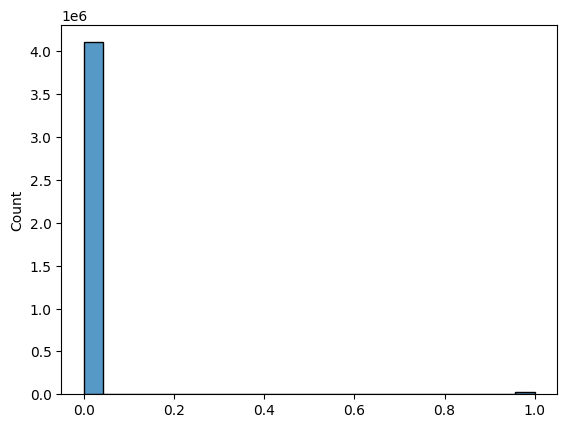

In [58]:
sns.histplot(scores.values.flatten())

In [59]:
scores = (scores + scores.T)/2

In [60]:
if not os.path.exists("scores/"): os.makedirs("scores/")
scores.to_csv(f"scores/scores_{MODEL}.csv")

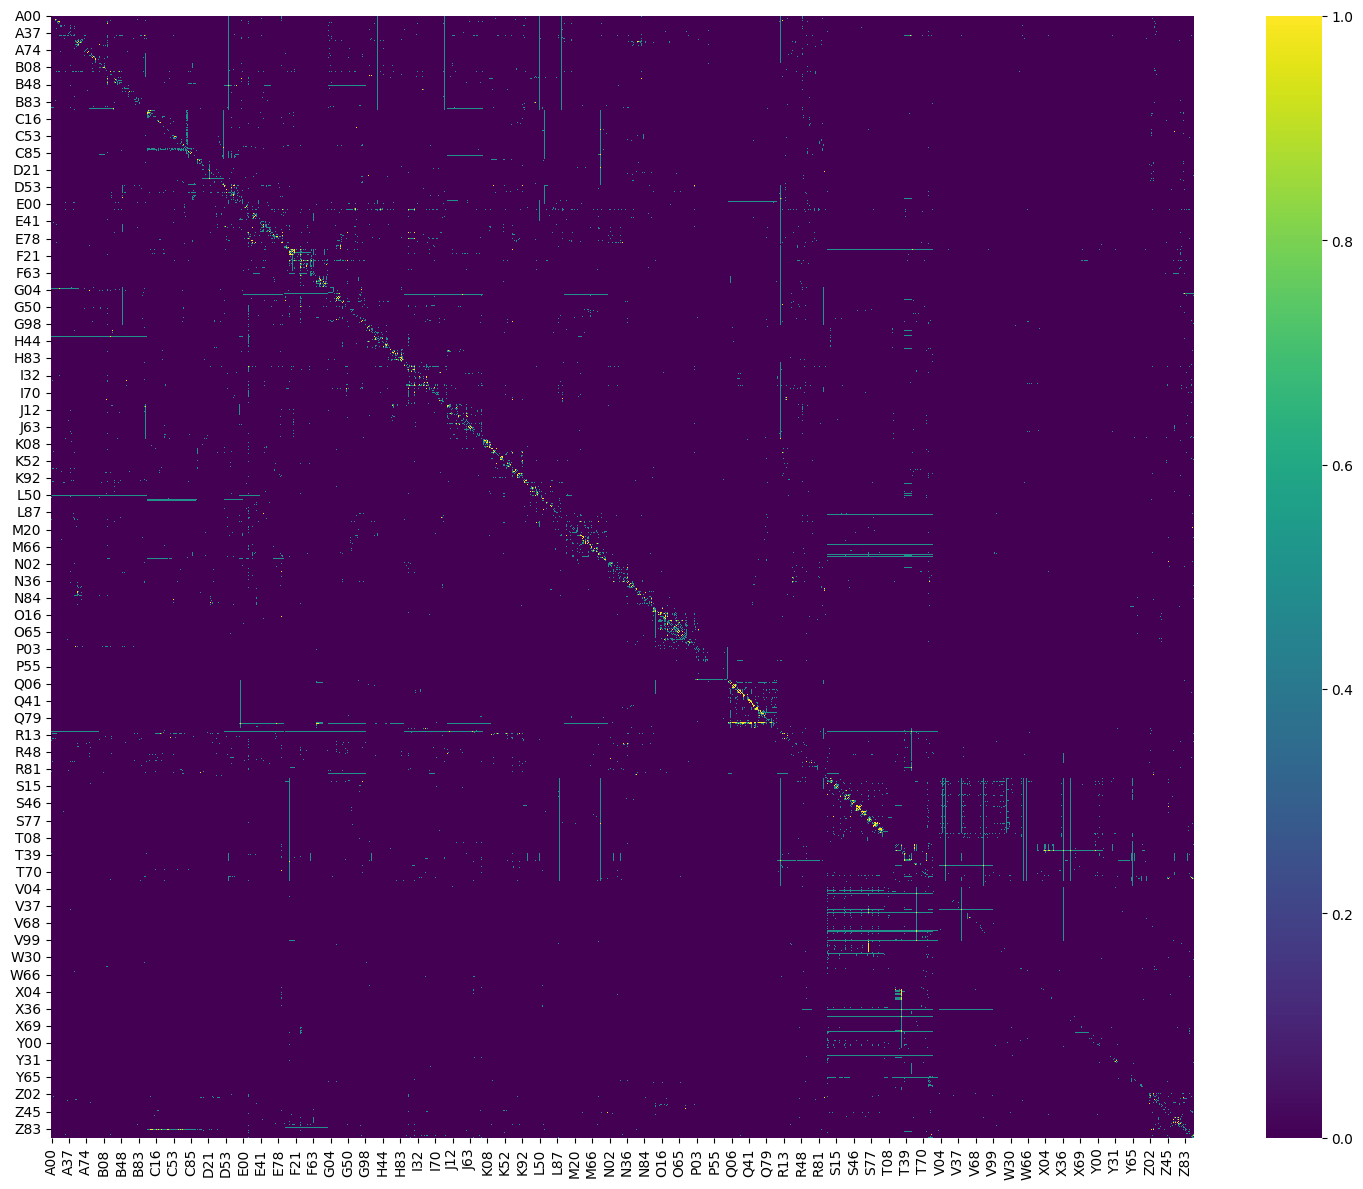

In [61]:
plt.figure(figsize=(15, 12))
sns.heatmap(scores, cmap ='viridis')
plt.tight_layout()
if not os.path.exists("pics/"): os.makedirs("pics/")
plt.savefig(f"pics/{MODEL}.png", dpi=300, bbox_inches='tight')
plt.show()